# Détecteur de Spam SMS - Analyse et Modélisation

Ce notebook présente l'analyse complète et la modélisation d'un détecteur de spam SMS utilisant le deep learning.

## Table des matières
1. [Installation des dépendances](#dependencies)
2. [Chargement des données](#data-loading)
3. [Analyse Exploratoire des Données](#eda)
4. [Prétraitement des données](#preprocessing)
5. [Modélisation](#modeling)
6. [Évaluation du modèle](#evaluation)
7. [Visualisations](#visualizations)

## 1. Installation des dépendances <a name="dependencies"></a>

Installation des bibliothèques nécessaires pour l'analyse et la modélisation.

In [1]:
!pip install pandas numpy scikit-learn tensorflow matplotlib seaborn wordcloud nltk

## 2. Import des bibliothèques

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, classification_report
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

# Télécharger les ressources NLTK nécessaires
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gillesakakpo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gillesakakpo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 3. Chargement des données <a name="data-loading"></a>

Chargement et préparation initiale du dataset.

In [3]:
#charger les données
df = pd.read_csv('spam.csv', encoding='iso-8859-1')
df = df[['v1', 'v2']]

# Renommer les colonnes
df.columns = ['label', 'message']

# Encoder les labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## 4. Analyse Exploratoire des Données <a name="eda"></a>

Analyse détaillée des données pour comprendre leur structure et leurs caractéristiques.

In [6]:
"""Analyse exploratoire des données"""
print("\n=== Analyse Exploratoire des Données ===")

# 1. Statistiques de base
print("\nStatistiques de base :")
print(f"Nombre total de messages : {len(df)}")
print(f"Distribution des classes :\n{df['label'].value_counts(normalize=True)}")


=== Analyse Exploratoire des Données ===

Statistiques de base :
Nombre total de messages : 5572
Distribution des classes :
label
0    0.865937
1    0.134063
Name: proportion, dtype: float64


In [7]:
# 2. Longueur des messages
df['message_length'] = df['message'].str.len()
print("\nStatistiques sur la longueur des messages :")
print(df['message_length'].describe())


Statistiques sur la longueur des messages :
count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: message_length, dtype: float64


Text(0, 0.5, 'Nombre de messages')

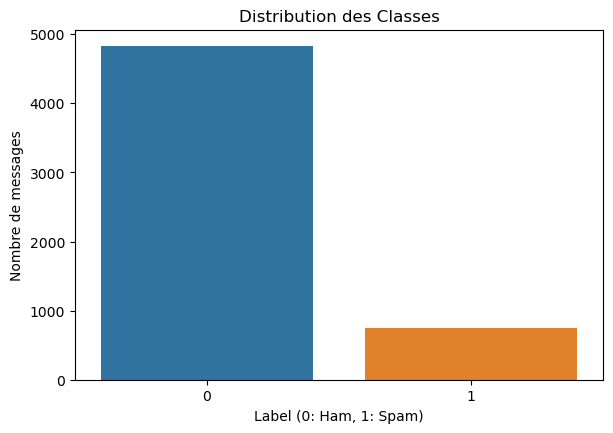

In [10]:
# 3. Visualisations
plt.figure(figsize=(15, 10))

# Distribution des classes
plt.subplot(2, 2, 1)
sns.countplot(data=df, x='label')
plt.title('Distribution des Classes')
plt.xlabel('Label (0: Ham, 1: Spam)')
plt.ylabel('Nombre de messages')

Text(0, 0.5, 'Longueur (caractères)')

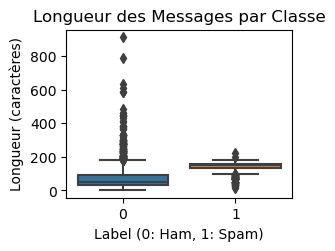

In [11]:
# Distribution de la longueur des messages
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='label', y='message_length')
plt.title('Longueur des Messages par Classe')
plt.xlabel('Label (0: Ham, 1: Spam)')
plt.ylabel('Longueur (caractères)')

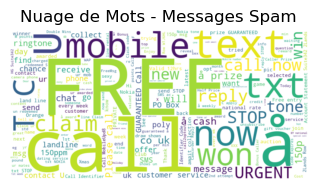

In [13]:
# Word Cloud pour les messages spam
plt.subplot(2, 2, 4)
spam_words = ' '.join(df[df['label'] == 1]['message'])
wordcloud_spam = WordCloud(width=800, height=400, background_color='white').generate(spam_words)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de Mots - Messages Spam')

plt.tight_layout()
plt.show()

In [14]:
# 4. Analyse des mots les plus fréquents
def get_most_common_words(texts, n=10):
    words = ' '.join(texts).lower()
    words = re.findall(r'\w+', words)
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    return Counter(words).most_common(n)

In [15]:
print("\nMots les plus fréquents dans les messages Ham :")
print(get_most_common_words(df[df['label'] == 0]['message']))

print("\nMots les plus fréquents dans les messages Spam :")
print(get_most_common_words(df[df['label'] == 1]['message']))


Mots les plus fréquents dans les messages Ham :
[('u', 1018), ('2', 322), ('gt', 318), ('lt', 316), ('get', 305), ('ok', 287), ('go', 249), ('ur', 241), ('know', 236), ('call', 236)]

Mots les plus fréquents dans les messages Spam :
[('call', 355), ('å', 299), ('free', 224), ('2', 206), ('u', 174), ('txt', 163), ('ur', 144), ('4', 137), ('mobile', 127), ('text', 125)]


## 5. Prétraitement des données <a name="preprocessing"></a>

Préparation des données pour l'entraînement du modèle.

In [16]:
def preprocess_text(texts, max_words=10000, max_len=100):
    # Créer le tokenizer
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    
    # Convertir les textes en séquences
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Padding des séquences
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    
    return padded_sequences, tokenizer

# Diviser en train et test
X_train, X_test, y_train, y_test = train_test_split(
    df['message'], df['label'], test_size=0.2, random_state=42
)

# Prétraiter les textes
max_words = 10000
max_len = 100
X_train_padded, tokenizer = preprocess_text(X_train, max_words, max_len)
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=max_len)

print("Forme des données d'entraînement :", X_train_padded.shape)
print("Forme des données de test :", X_test_padded.shape)

Forme des données d'entraînement : (4457, 100)
Forme des données de test : (1115, 100)


## 6. Création et Entraînement du Modèle <a name="modeling"></a>

Construction et entraînement du modèle LSTM.

In [17]:
def create_model(max_words, max_len):
    model = Sequential([
        Embedding(max_words, 32, input_length=max_len),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Créer le modèle
model = create_model(max_words, max_len)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Early stopping pour éviter le surapprentissage
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Entraînement
history = model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8547 - loss: 0.4092 - val_accuracy: 0.9787 - val_loss: 0.0873
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9893 - loss: 0.0553 - val_accuracy: 0.9877 - val_loss: 0.0565
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9944 - loss: 0.0233 - val_accuracy: 0.9877 - val_loss: 0.0524
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9982 - loss: 0.0098 - val_accuracy: 0.9865 - val_loss: 0.0566
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9995 - loss: 0.0038 - val_accuracy: 0.9843 - val_loss: 0.0638
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 1.0000 - loss: 8.5768e-04 - val_accuracy: 0.9877 - val_loss: 0.0717


## 7. Évaluation du Modèle <a name="evaluation"></a>

Évaluation des performances du modèle sur l'ensemble de test.

In [19]:
# Évaluer le modèle
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

# Prédictions
y_pred = (model.predict(X_test_padded) > 0.5).astype(int)

# Rapport de classification
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9857 - loss: 0.0552

Test accuracy: 0.9812
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Rapport de classification :
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.88      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



## 8. Visualisations <a name="visualizations"></a>

Visualisation des résultats et des performances du modèle.

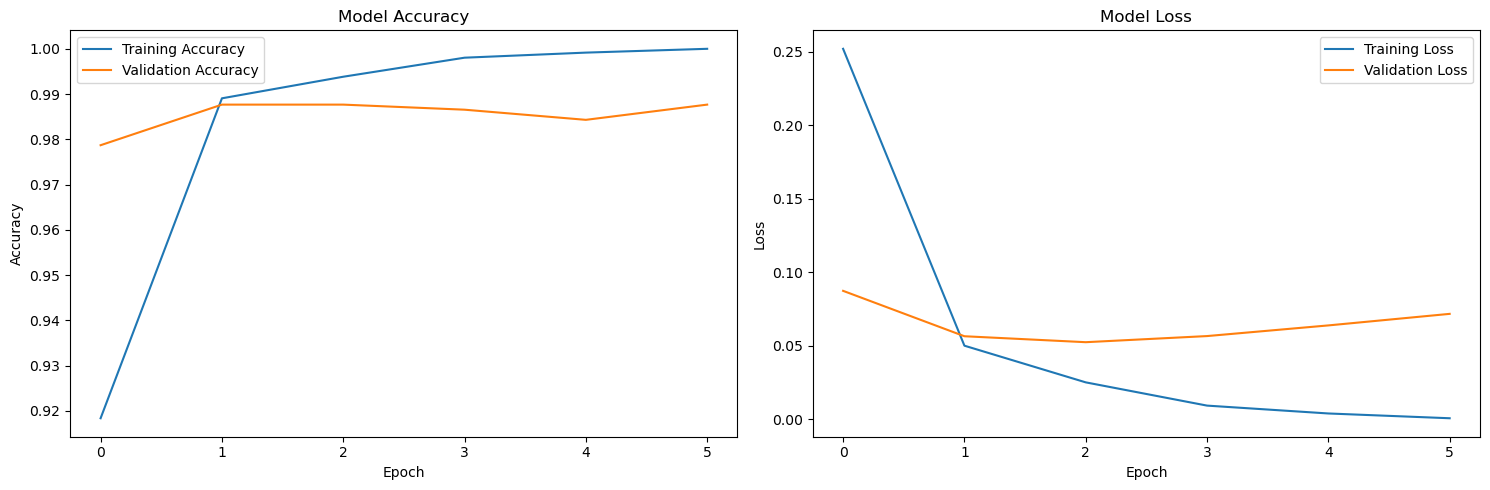

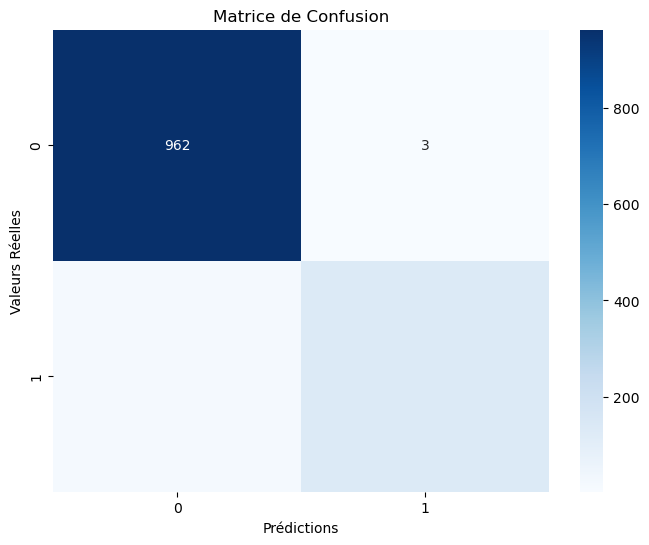

In [20]:
def plot_training_history(history):
    """Visualisation de l'historique d'entraînement"""
    plt.figure(figsize=(15, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """Visualisation de la matrice de confusion"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice de Confusion')
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs Réelles')
    plt.show()

# Afficher les visualisations
plot_training_history(history)
plot_confusion_matrix(y_test, y_pred)

## 9. Sauvegarde du Modèle

Sauvegarde du modèle entraîné pour une utilisation future.

In [21]:
# Sauvegarder le modèle
model.save('spam_detector_model.h5')
print("Modèle sauvegardé avec succès !")

Modèle sauvegardé avec succès !
